In [76]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import random
import string
import re

import nltk
from nltk.corpus import stopwords, words
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import plot_confusion_matrix, roc_curve
from sklearn.decomposition import NMF

# nltk.download('words')

In [27]:
# chyron archive web address: https://archive.org/services/third-eye.php

import datetime

# pull chyrons from web as dataframes
def get_dfs(start_y=2017, start_m=9, start_d=7, end_today=True, end_y=None, end_m=None, end_d=None):
    
    first = datetime.date(start_y, start_m, start_d)
    delta = datetime.timedelta(weeks=1)
    last = first + delta
    dfs = []
    iters = 0
    
    if end_today:
        stop = datetime.date.today()
    else:
        stop = datetime.date(end_y, end_m, end_d)
    
    while first < stop:
        if iters > 210:
            break
        else:
            print(iters)
            first_str = first.strftime('%m/%d/%y')
            last_str = last.strftime('%m/%d/%y')
            url = f'https://archive.org/services/third-eye.php?dayL={first_str}&dayR={last_str}'
            df = pd.read_csv(url, delimiter='\t')
            dfs.append(df)

            first = last + datetime.timedelta(days=1)
            last = first + delta
            
            if last > stop:
                last = stop
                
            iters += 1
        
    return dfs

# cleans dfs
def clean_dfs(df, csv=True, concat=False, csv_name='chyron_next'):
    
    # stack dfs from list
    if concat:
        df = pd.concat(df, ignore_index=True)
        
    # drop duplicates
    df.drop_duplicates(subset=['text'], keep='first', inplace=True, ignore_index=True)
    
    # count words in chyron 
    df['num_words'] = df['text'].apply(lambda x: len(x.split()) if isinstance(x, str) else 'NaN')
    
    # save to local csv          
    if csv:
        df.to_csv(f'/Users/jonleckie/Desktop/DSI_all/capstones/capstone_two/chyrons/{csv_name}.csv')    
    
    return df

# wrapper for above functions --> NOT TESTED
def get_chyrons(start_y=2017, start_m=9, start_d=7, end_today=True, end_y=None, end_m=None, end_d=None):
    df = get_dfs(start_y, start_m, start_d, end_today, end_y, end_m, end_d)
    df = clean_dfs(df, csv=True, concat=False, csv_name='chyron2')
    return df

In [95]:
chyrons.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2652398 entries, 0 to 2652397
Data columns (total 6 columns):
 #   Column                        Non-Null Count    Dtype  
---  ------                        --------------    -----  
 0   date_time_(UTC)               2652398 non-null  object 
 1   channel                       2652397 non-null  object 
 2   duration                      2652397 non-null  float64
 3   https://archive.org/details/  2647435 non-null  object 
 4   text                          2652397 non-null  object 
 5   num_words                     205492 non-null   float64
dtypes: float64(2), object(4)
memory usage: 121.4+ MB


### Distributions of word counts:

* All networks

(array([9.24212e+05, 9.55745e+05, 7.21145e+05, 5.18620e+04, 1.21500e+03,
        1.29000e+02, 1.70000e+01, 1.00000e+01, 7.00000e+00, 4.00000e+00]),
 array([1.0, 13.4, 25.8, 38.2, 50.6, 63.0, 75.4, 87.8, 100.2,
        112.60000000000001, 125.0], dtype=object),
 <BarContainer object of 10 artists>)

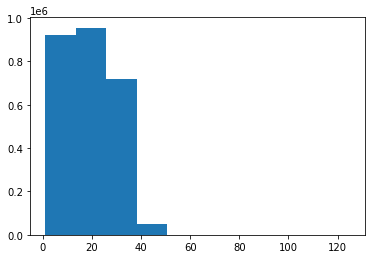

In [53]:
plt.hist(chryon_all['num_words'])

(array([475551.,      0.,      0., 775759.,      0.,      0., 685712.,
             0.,      0., 717324.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <BarContainer object of 10 artists>)

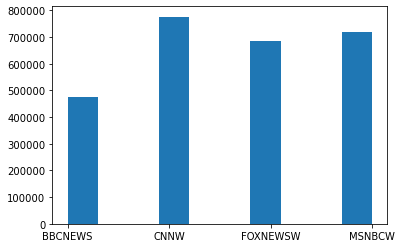

In [54]:
# distribution of entries per network

plt.hist(chryon_all['channel']);

In [57]:
chryon_all.channel.unique()

array(['BBCNEWS', 'CNNW', 'FOXNEWSW', 'MSNBCW'], dtype=object)

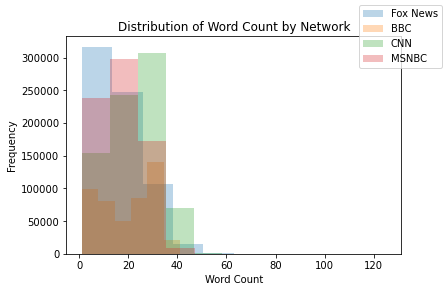

In [59]:
# distribution of word counts
fig, ax = plt.subplots()

fox = chryon_all[chryon_all['channel'] == 'FOXNEWSW']
bbc = chryon_all[chryon_all['channel'] == 'BBCNEWS']
cnn = chryon_all[chryon_all['channel'] == 'CNNW']
msnbc = chryon_all[chryon_all['channel'] == 'MSNBCW']

ax.hist(fox['num_words'], label='Fox News', alpha=0.3)
ax.hist(bbc['num_words'], label='BBC', alpha=0.3)
ax.hist(cnn['num_words'], label='CNN', alpha=0.3)
ax.hist(msnbc['num_words'], label='MSNBC', alpha=0.3)
ax.set_ylabel('Frequency')
ax.set_xlabel('Word Count')
ax.set_title('Distribution of Word Count by Network')
fig.legend();

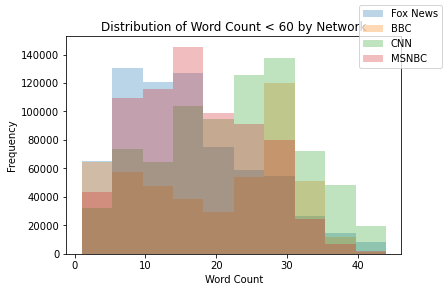

In [73]:
# distribution of word counts under 60
fig, ax = plt.subplots()

fox = chryon_all[(chryon_all['channel'] == 'FOXNEWSW') & (chryon_all['num_words'] < 60)]
bbc = chryon_all[(chryon_all['channel'] == 'BBCNEWS') & (chryon_all['num_words'] < 60)]
cnn = chryon_all[(chryon_all['channel'] == 'CNNW') & (chryon_all['num_words'] < 60)]
msnbc = chryon_all[(chryon_all['channel'] == 'MSNBCW') & (chryon_all['num_words'] < 60)]

ax.hist(fox['num_words'], label='Fox News', alpha=0.3)
ax.hist(bbc['num_words'], label='BBC', alpha=0.3)
ax.hist(cnn['num_words'], label='CNN', alpha=0.3)
ax.hist(msnbc['num_words'], label='MSNBC', alpha=0.3)
ax.set_ylabel('Frequency')
ax.set_xlabel('Word Count')
ax.set_title('Distribution of Word Count < 60 by Network')
fig.legend();

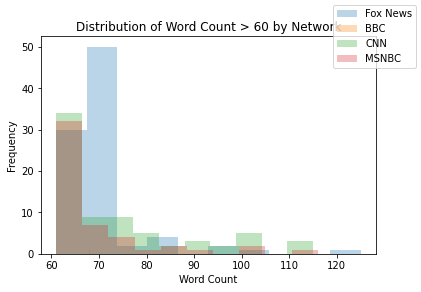

In [62]:
# distribution of word counts under 60
fig, ax = plt.subplots()

fox = chryon_all[(chryon_all['channel'] == 'FOXNEWSW') & (chryon_all['num_words'] > 60)]
bbc = chryon_all[(chryon_all['channel'] == 'BBCNEWS') & (chryon_all['num_words'] > 60)]
cnn = chryon_all[(chryon_all['channel'] == 'CNNW') & (chryon_all['num_words'] > 60)]
msnbc = chryon_all[(chryon_all['channel'] == 'MSNBCW') & (chryon_all['num_words'] > 60)]

ax.hist(fox['num_words'], label='Fox News', alpha=0.3)
ax.hist(bbc['num_words'], label='BBC', alpha=0.3)
ax.hist(cnn['num_words'], label='CNN', alpha=0.3)
ax.hist(msnbc['num_words'], label='MSNBC', alpha=0.3)
ax.set_ylabel('Frequency')
ax.set_xlabel('Word Count')
ax.set_title('Distribution of Word Count > 60 by Network')
fig.legend();

In [2]:
# sklearn pipeline 

# english dictionary 
eng_dict = words.words()

# get a random sample of chyrons
def get_random_sample(df, num_samples):
    idx_lst = [num for num in range(len(df))]
    idx_samps = random.sample(idx_lst, num_samples)
    df_samp = df.iloc[idx_samps]
    return df_samp

# get stop words
def get_stop_words(words):
    sw = stopwords.words('english')
    stops = words[0]
    
    for lst in words[1:]:
        stops += lst
    
    return sw + stops

## ------------------------------------------------------ ##

# sklearn count vectorizer
def get_countvec(corpus, stop_words='english', min_df=.01):
    vectorizer = CountVectorizer(stop_words=stop_words, min_df=min_df)
    X = vectorizer.fit_transform(corpus)
    feature_names = vectorizer.get_feature_names()
    
    return feature_names, X.toarray()

# sklearn tfidf vectorizer
def get_tfidf(corpus, max_features=None, min_df=.01, stop_words='english'):
    vectorizer = TfidfVectorizer(max_features=None, min_df=min_df, max_df=1.0, stop_words='english')
    X = vectorizer.fit_transform(corpus)
    feature_names = vectorizer.get_feature_names()
    
    return feature_names, X.toarray()

# vectorizer to dataframe
def get_dataframe(X, feature_names):
    df = pd.DataFrame(data = X, columns = feature_names)
    return df

## ------------------------------------------------------ ##

# odd word functions

def get_numeric_words(feature_names):
    stops = set()
    nums = [str(num) for num in range(10)]
    
    for word in feature_names:
        for char in word:
            if char in nums:
                stops.add(word)
                break
                
    return list(stops)

def get_non_alpha_start(feature_names):
    non_alpha = []
    alpha = list(string.ascii_lowercase)
    for name in feature_names:
        if name[0] not in alpha:
            non_alpha.append(name)
            
    return non_alpha

def get_underscores(feature_names):
    unders = []
    for name in feature_names:
        if '_' in name:
            unders.append(name)
            
    return unders

def get_multis(feature_names):
    multi = []
    for name in feature_names:
        if len(name) == 2:
            if name[0] == name[1]:
                multi.append(name)
        else:
            search = re.search(r"([A-Za-z])\1\1", name)
            if search != None:
                multi.append(name)
                
    return multi

# wrap for above 
def get_special_stops(feature_names):
    numeric = get_numeric_words(feature_names)
    non_alpha = get_non_alpha_start(feature_names)
    unders = get_underscores(feature_names)
    multi_lett = get_multis(feature_names)
    
    return [numeric, non_alpha, unders, multi_lett]


## ------------------------------------------------------ ##

# PIPELINE FOR Counts:

def load_samps(num_samples):
    chyrons = pd.read_csv('/Users/jonleckie/Desktop/DSI_all/capstones/capstone_two/chyrons/chyron_all.csv') # read all data
    chyrons.drop(472372, inplace=True) # drop single NaN value
    chy_samp = get_random_sample(chyrons, num_samples) # random sample for working locally 
    
    return chy_samp
    
def clean_counts(chy_samp, min_df=.001):
    count_features, chyron_counts = get_countvec(chy_samp['text'], stop_words='english', min_df=min_df) # get primary feature names
    stops = get_special_stops(count_features) # get additional stop words
    stop_words_plus = get_stop_words(stops) # add to nltk stop words
    count_features, chyron_counts = get_countvec(chy_samp['text'], stop_words=stop_words_plus, min_df=min_df) # get new vector matrix

    return count_features, chyron_counts

def clean_tfidf(chy_samp, min_df=.001):
    tfidf_features, chyron_tfidf = get_tfidf(chy_samp['text'], max_features=None, min_df=min_df, stop_words='english') # get primary feature names
    stops = get_special_stops(tfidf_features) # get additional stop words
    stop_words_plus = get_stop_words(stops) # add to nltk stop words
    tfidf_features, chyron_tfidf = get_tfidf(chy_samp['text'], max_features=None, min_df=min_df, stop_words=stop_words_plus) # get new vector matrix

    return tfidf_features, chyron_tfidf

In [3]:
# get data from summer 2020, MSNBC and Fox

def load_summer(start_date='2020-05-25', end_date='2020-11-03'):
    chyrons = pd.read_csv('/Users/jonleckie/Desktop/DSI_all/capstones/capstone_two/chyrons/chyron_all.csv')
    chyrons.drop(472372, inplace=True)
    chy_summer = chyrons.loc[(chyrons['date_time_(UTC)'] >= start_date) & (chyrons['date_time_(UTC)'] <= end_date)]
    
    return chy_summer

def get_network_pair(df, net_one='FOXNEWSW', net_two='MSNBCW'):
    chy_nets = df.loc[(df['channel'] == net_one) | (df['channel'] == net_two)]
    
    return chy_nets

chy_summer = load_summer()
chy_nets = get_network_pair(chy_summer, net_one='FOXNEWSW', net_two='MSNBCW')
feature_count, count_vec = clean_counts(chy_nets)
feature_tfidf, tfidf_vec = clean_tfidf(chy_nets)

In [4]:
chy_summer = load_summer()
chy_nets = get_network_pair(chy_summer, net_one='FOXNEWSW', net_two='MSNBCW')
feature_count, count_vec = clean_counts(chy_nets)
feature_tfidf, tfidf_vec = clean_tfidf(chy_nets)

In [5]:
chy_nets = get_network_pair(chy_summer, net_one='FOXNEWSW', net_two='MSNBCW')

In [6]:
len(chy_nets)

182424

In [8]:
feature_count, count_vec = clean_counts(chy_nets)
feature_tfidf, tfidf_vec = clean_tfidf(chy_nets)

In [205]:
tfidf_vec.shape

(182424, 1943)

### Start Setting Up Models

In [109]:
doc_freq = .2

chy_samps = load_samps(num_samples=250000)
count_features, chyron_counts = clean_counts(chy_samps, min_df=doc_freq)
tfidf_features, chyron_tfidf = clean_tfidf(chy_samps, min_df=doc_freq)

In [110]:
# X, y for original random sample 

# X_counts = get_dataframe(chyron_counts, count_features)
# X_tfidf = get_dataframe(chyron_tfidf, tfidf_features)
# y = chy_samps['channel']

In [9]:
# X, y for summer tests on Fox and MSNBC
X_counts = get_dataframe(count_vec, feature_count)
# X_tfidf = get_dataframe(tfidf_vec, feature_tfidf)
y = chy_nets['channel']

In [11]:
# first split:
X_train, X_test, y_train, y_test = train_test_split(X_counts, y, train_size=0.33, shuffle=True, stratify=y)
X_train_T, X_test_T, y_train_T, y_test_T = train_test_split(X_tfidf, y, train_size=0.33, shuffle=True, stratify=y)

In [12]:
len(X_counts), len(X_tfidf), len(y)

(182424, 182424, 182424)

#### Multinomial Naive Bayes

In [13]:
def eval_naive_bayes(X, y, folds=10):
    kf = KFold(n_splits=folds, shuffle=True)
    accuracy = []
    
    for train, test in kf.split(X):
        model = MultinomialNB(alpha=1.0, fit_prior=False)
        model.fit(X.iloc[train], y.iloc[train])
#         y_hat = model.predict(X.iloc[test])
        accuracy.append(model.score(X.iloc[test], y.iloc[test]))
    
    return np.mean(accuracy)

def test_folds(X, y, fold_lst):
    accuracy = []
    iters = 0
    for folds in fold_lst:
        print(iters)
        accuracy.append(eval_naive_bayes(X, y, folds=folds))
        
        iters += 1
        
    return accuracy

def plot_naive_bayes(X, y, fold_lst):
    fig, ax = plt.subplots()
    xs = fold_lst
    ys = test_folds(X, y, fold_lst)
    ax.plot(xs, ys)
    ax.set_title('Naive Bayes Accuracy by Num_Folds')
    ax.set_ylabel('Accuracy')
    ax.set_xlabel('Folds');

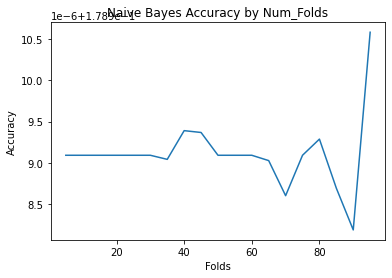

In [116]:
# Bayes fold test with CountVec
folds = list(range(5, 100, 5))
plot_naive_bayes(X_train, y_train, folds)

In [113]:
eval_naive_bayes(X_train_T, y_train_T, folds=100)

0.292230303030303

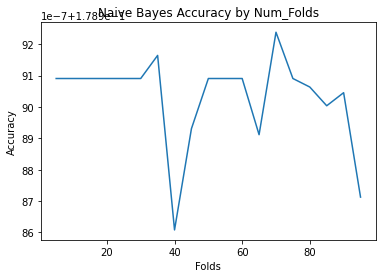

In [122]:
# Bayes fold test with TfidfVec
folds = list(range(5, 100, 5))
plot_naive_bayes(X_train_T, y_train_T, folds)

In [72]:
def _naive_bayes(X, y, folds=20, fit_prior=False):
    kf = KFold(n_splits=folds, shuffle=True)
    accuracy = []
    
    for train, test in kf.split(X):
        model = MultinomialNB(alpha=1, fit_prior=fit_prior)
        model.fit(X.iloc[train], y.iloc[train])
        accuracy.append(model.score(X.iloc[test], y.iloc[test]))
    
    return model, np.mean(accuracy)

In [118]:
y_hat, _y_test, model = _naive_bayes(X_train, y_train)

In [120]:
correct = 0
for i in range(len(y_hat)):
    if y_hat[i] == _y_test[i]:
        correct += 1
        
correct / len(_y_test)

0.1789090909090909

In [91]:
len(X_test), len(y_test)

(167500, 20625)

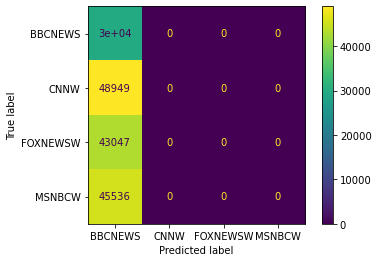

In [121]:
plot_confusion_matrix(model, X_test, y_test)  
plt.show()

In [96]:
d = {}
for elem in y_test:
    if elem not in d:
        d[elem] = 1
    d[elem] += 1

In [100]:
for k, v in d.items():
    print(f'{k}:{v} --> {round(v/sum(d.values()), 4) * 100}%')

MSNBCW:45104 --> 26.93%
BBCNEWS:30376 --> 18.13%
CNNW:48954 --> 29.23%
FOXNEWSW:43070 --> 25.71%


In [128]:
T_y_hat, T_y_test, T_model, T_accuracy = _naive_bayes(X_train_T, y_train_T)

0.1789093825427889


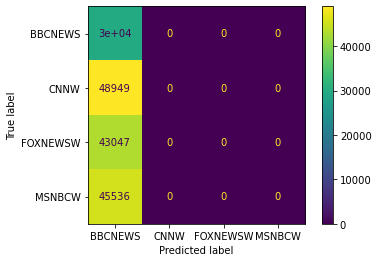

In [129]:
print(T_accuracy)
plot_confusion_matrix(T_model, X_test_T, y_test_T)  
plt.show()

##### With only summer for MSNBC/Fox

In [213]:
model, score = _naive_bayes(X_train, y_train)

In [214]:
score

0.7709763511238158

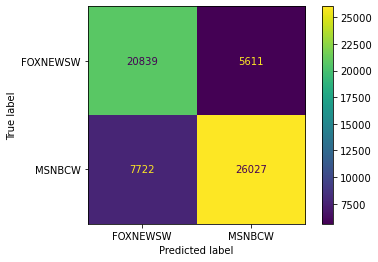

In [215]:
plot_confusion_matrix(model, X_train, y_train)  
plt.show()

0.7709265227573094


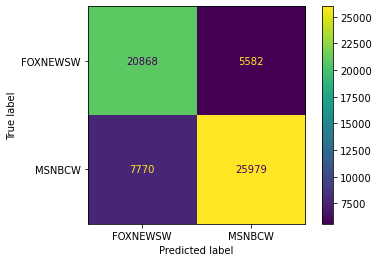

In [15]:
model, score = _naive_bayes(X_train, y_train)
print(score)
plot_confusion_matrix(model, X_train, y_train)  
plt.show()

In [ ]:
folds = list(range(5, 20, 5))
plot_naive_bayes(X_train, y_train, folds)

0.7662751446656708


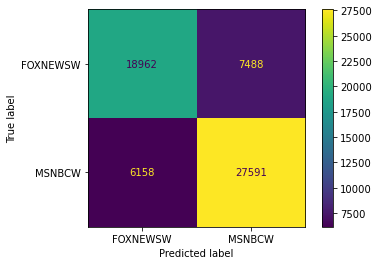

In [28]:
model, score = _naive_bayes(X_train, y_train, fit_prior=True)
print(score)
plot_confusion_matrix(model, X_train, y_train)  
plt.show()

In [69]:
def plot_roc(X, y, vec_type='Count'):
    y_net = [1 if net == 'MSNBCW' else 0 for net in y]
    X_train, X_test, y_train, y_test = train_test_split(X, y_net, train_size=0.33, shuffle=True, stratify=y)
    fig, ax = plt.subplots()
    
    model = MultinomialNB()
    model.fit(X_train, y_train)
    y_hat = model.predict_proba(X_test)
    fpr, tpr, thresh = roc_curve(y_test, y_hat[:, 1])
    
    ax.plot(fpr, tpr)
    ax.plot([0,1], [0,1], ls='--', color='k')
    ax.set_title(f'Naive Bayes ROC Curve {vec_type}')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    
    return thresh

array([2.00000000e+00, 1.00000000e+00, 1.00000000e+00, ...,
       4.64578677e-13, 3.10342080e-13, 6.22990360e-16])

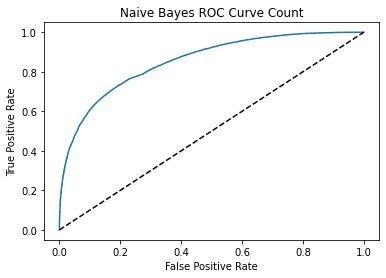

In [70]:
plot_roc(X_train, y_train)

0.7927873301468794


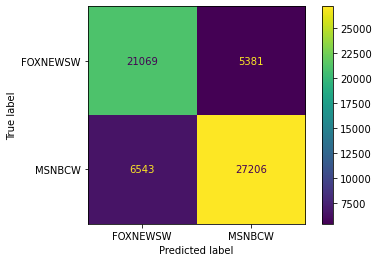

In [74]:
model, score = _naive_bayes(X_train_T, y_train_T, fit_prior=False)
print(score)
plot_confusion_matrix(model, X_train_T, y_train_T)  
plt.show()

array([1.99926543, 0.99926543, 0.98920947, ..., 0.00881591, 0.00877571,
       0.00290312])

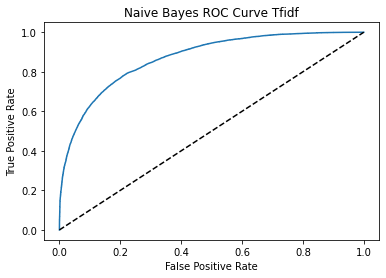

In [71]:
plot_roc(X_train_T, y_train_T, vec_type='Tfidf')

#### Random Forest Classifier

In [20]:
 def eval_random_forest(X, y, folds=10, n_estimators=100, max_depth=5, max_leaf=None, max_features='log2'):
    kf = KFold(n_splits=folds, shuffle=True)
    accuracy = []
    iters = 0
    
    for train, test in kf.split(X):
        forest = RandomForestClassifier(n_estimators=n_estimators, 
                                        max_depth=max_depth, n_jobs=-1, 
                                        max_leaf_nodes=max_leaf, max_features=max_features)
        forest.fit(X.iloc[train], y.iloc[train])
        accuracy.append(forest.score(X.iloc[test], y.iloc[test]))
        
        print(iters)
        iters += 1
    
    return np.mean(accuracy), forest

In [159]:
score, model = eval_random_forest(X_train, y_train, folds=10, 
                                  n_estimators=10, max_depth=10, max_leaf=None)
print(score)

0.31232727272727273


0.31224242424242427 =  folds=10, n_estimators=100, max_depth=5, max_leaf=None

0.31224242424242427 =  folds=10, n_estimators=10, max_depth=5, max_leaf=None

0.31224242424242427 =  folds=10, n_estimators=10, max_depth=10, max_leaf=None

0.3122060606060606  =  folds=10, n_estimators=100, max_depth=10, max_leaf=100

0.3122787878787879  =  folds=100, n_estimators=100, max_depth=10, max_leaf=100

0.31220606060606065 = folds=10, n_estimators=10, max_depth=10, max_leaf=10

In [154]:
model.n_features_

1

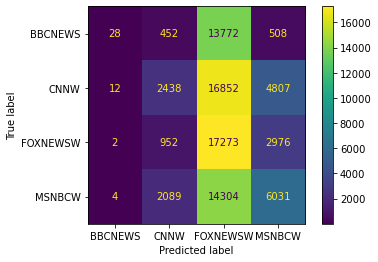

In [138]:
# 0.31224242424242427 =  folds=10, n_estimators=100, max_depth=5, max_leaf=None
plot_confusion_matrix(model, X_train, y_train)  
plt.show()

In [17]:
def test_forest_folds(X, y, fold_lst):
    accuracy = []
    for folds in fold_lst:
        accuracy.append(eval_random_forest(X, y, folds=folds))
        
    return accuracy

def test_forest_depth(X, y, depth_lst):
    accuracy = []
    for depth in depth_lst:
        accuracy.append(eval_random_forest(X, y, max_depth=depth))
        
    return accuracy

def test_forest_estimators(X, y, est_lst):
    accuracy = []
    for est in est_lst:
        accuracy.append(eval_random_forest(X, y, n_estimators=est, max_depth=50))
        
    return accuracy

def test_max_leafs(X, y, leaf_lst):
    accuracy = []
    for leaf in leaf_lst:
        accuracy.append(eval_random_forest(X, y, max_leaf=leaf))
        
    return accuracy

def plot_folds_random_forest_folds(X, y, fold_lst):
    fig, ax = plt.subplots()
    xs = fold_lst
    ys = test_forest_folds(X, y, fold_lst)
    ax.plot(xs, ys)
    ax.set_title('Random Forest Accuracy by Folds')
    ax.set_ylabel('Accuracy')
    ax.set_xlabel('Folds');
    
def plot_depth_random_forest(X, y, depth_lst):
    fig, ax = plt.subplots()
    xs = depth_lst
    ys = test_forest_depth(X, y, depth_lst)
    ax.plot(xs, ys)
    ax.set_title('Random Forest Accuracy by Depth')
    ax.set_ylabel('Accuracy')
    ax.set_xlabel('Depth');

In [164]:
depth = [5, 10, 20, 30, 100]
test_forest_depth(X_train, y_train, depth)

[(0.31220606060606054,
  RandomForestClassifier(max_depth=5, max_features=None, n_estimators=10,
                         n_jobs=-1)),
 (0.31231515151515155,
  RandomForestClassifier(max_depth=10, max_features=None, n_estimators=10,
                         n_jobs=-1)),
 (0.31225454545454545,
  RandomForestClassifier(max_depth=20, max_features=None, n_estimators=10,
                         n_jobs=-1)),
 (0.31225454545454545,
  RandomForestClassifier(max_depth=30, max_features=None, n_estimators=10,
                         n_jobs=-1)),
 (0.3122181818181818,
  RandomForestClassifier(max_depth=100, max_features=None, n_estimators=10,
                         n_jobs=-1))]

In [176]:
test_forest_depth(X_train, y_train, [500])

[(0.31221818181818184,
  RandomForestClassifier(max_depth=500, max_features=None, n_jobs=-1))]

In [170]:
estimators = [5, 10, 20, 30, 50]
test_forest_estimators(X_train, y_train, estimators)

[(0.31225454545454545,
  RandomForestClassifier(max_depth=50, max_features=None, n_estimators=5,
                         n_jobs=-1)),
 (0.312169696969697,
  RandomForestClassifier(max_depth=50, max_features=None, n_estimators=10,
                         n_jobs=-1)),
 (0.3122666666666667,
  RandomForestClassifier(max_depth=50, max_features=None, n_estimators=20,
                         n_jobs=-1)),
 (0.3122545454545454,
  RandomForestClassifier(max_depth=50, max_features=None, n_estimators=30,
                         n_jobs=-1)),
 (0.312230303030303,
  RandomForestClassifier(max_depth=50, max_features=None, n_estimators=50,
                         n_jobs=-1))]

In [177]:
leafs = [5, 10, 20, 30, 50]
test_max_leafs(X, y, leafs)

[(0.2632,
  RandomForestClassifier(max_depth=5, max_features=None, max_leaf_nodes=5,
                         n_jobs=-1)),
 (0.2632,
  RandomForestClassifier(max_depth=5, max_features=None, max_leaf_nodes=10,
                         n_jobs=-1)),
 (0.27559999999999996,
  RandomForestClassifier(max_depth=5, max_features=None, max_leaf_nodes=20,
                         n_jobs=-1)),
 (0.25360000000000005,
  RandomForestClassifier(max_depth=5, max_features=None, max_leaf_nodes=30,
                         n_jobs=-1)),
 (0.2604,
  RandomForestClassifier(max_depth=5, max_features=None, max_leaf_nodes=50,
                         n_jobs=-1))]

In [139]:
score_T, model_T = eval_random_forest(X_train_T, y_train_T)
print(score)

0.31224242424242427


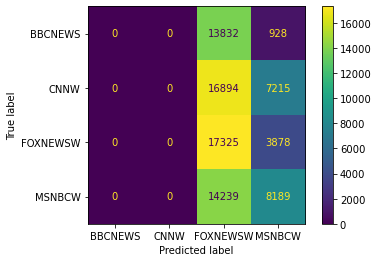

In [140]:
plot_confusion_matrix(model_T, X_train_T, y_train_T)  
plt.show()

##### With only summer for MSNBC/Fox

In [24]:
score, model = eval_random_forest(X_train, y_train, folds=5, n_estimators=10, max_depth=10, max_leaf=10)
print(score)

0
1
2
3
4
0.5805743487596651


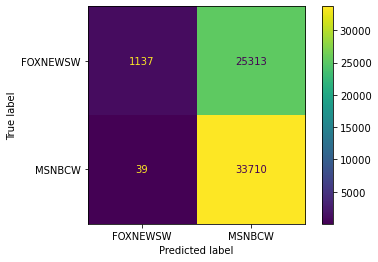

In [25]:
plot_confusion_matrix(model, X_train, y_train)  
plt.show()

In [22]:
score, model = eval_random_forest(X_train, y_train, folds=10, n_estimators=100, max_depth=10, max_leaf=10)
print(score)

0
1
2
3
4
5
6
7
8
9
0.5659229632189098


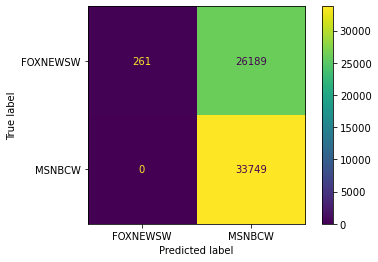

In [23]:
plot_confusion_matrix(model, X_train, y_train)  
plt.show()

In [19]:
X_train.shape

(60199, 1901)

In [75]:
depth = [5, 10, 20, 30, 100]
test_forest_depth(X_train, y_train, depth)

0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9


[(0.5608897240686883,
  RandomForestClassifier(max_depth=5, max_features='log2', n_jobs=-1)),
 (0.5713715675554543,
  RandomForestClassifier(max_depth=10, max_features='log2', n_jobs=-1)),
 (0.6248443191245441,
  RandomForestClassifier(max_depth=20, max_features='log2', n_jobs=-1)),
 (0.6737985802434043,
  RandomForestClassifier(max_depth=30, max_features='log2', n_jobs=-1)),
 (0.8132361116707392,
  RandomForestClassifier(max_depth=100, max_features='log2', n_jobs=-1))]

##### ROC Curve

In [78]:
def plot_roc_forest(X, y, vec_type='(Count)'):
    y_net = [1 if net == 'MSNBCW' else 0 for net in y]
    X_train, X_test, y_train, y_test = train_test_split(X, y_net, train_size=0.33, shuffle=True, stratify=y)
    fig, ax = plt.subplots()
    
    model = RandomForestClassifier()
    model.fit(X_train, y_train)
    y_hat = model.predict_proba(X_test)
    fpr, tpr, thresh = roc_curve(y_test, y_hat[:,1])
    
    ax.plot(fpr, tpr)
    ax.plot([0,1], [0,1], ls='--', color='k')
    ax.set_title(f'Random Forest ROC Curve {vec_type}')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    
    return thresh

KeyboardInterrupt: 

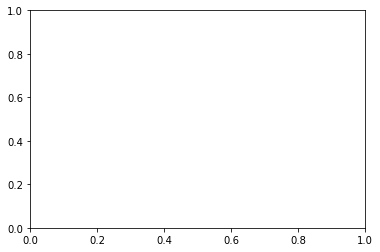

In [79]:
plot_roc_forest(X_train, y_train)

##### EDA

In [29]:
word_counts = get_dataframe(count_vec, feature_count)

In [32]:
word_counts['network'] = chy_nets['channel']

In [38]:
type(chy_nets['channel']), type(word_counts)

(pandas.core.series.Series, pandas.core.frame.DataFrame)

In [41]:
word_counts = word_counts.assign(network=chy_nets['channel'].values)

In [56]:
fox_words = word_counts.loc[word_counts['network'] == 'FOXNEWSW']
nbc_words = word_counts.loc[word_counts['network'] == 'MSNBCW']

In [57]:
fox_words.drop('network', axis=1, inplace=True)
top_fox_words = fox_words.sum().sort_values(ascending=False)

In [58]:
nbc_words.drop('network', axis=1, inplace=True)
top_nbc_words = nbc_words.sum().sort_values(ascending=False)

In [59]:
top_fox_words[:25]

trump          21833
biden          10125
president       6930
police          6763
new             4078
covid           3725
protests        3463
court           3384
house           3230
news            3202
com             3141
ntrump          2993
fox             2904
campaign        2587
cities          2476
election        2443
ni              2430
debate          2314
supreme         2264
violence        2244
coronavirus     2173
white           2146
floyd           2138
america         2061
protesters      2003
dtype: int64

In [60]:
top_nbc_words[:25]

trump          45798
biden          12457
ntrump          9398
covid           9234
cases           8890
new             8530
virus           8045
police          6548
house           5862
election        5545
says            5321
coronavirus     5062
protests        4797
white           4376
ni              4248
floyd           4150
campaign        4137
pres            3951
harris          3814
president       3777
death           3683
states          3671
court           3529
news            3491
george          3303
dtype: int64

##### NMF

In [ ]:
def fit_nmf(X, n_components=2):
    
    nmf = NMF(n_components=n_components)
    W = nmf.fit_transform(X)
    H = nmf.components_